# 第十一週：Text Presentation
本周課程為「Text Presentation」，主要會使用到gensim套件來實現自行訓練word2vec模型以及使用預訓練word2vec模型，以及透過sentence-transformers以及API取得embeddings。


### 大綱：
1.   DEMO
*   Word2Vec
  *   自己訓練w2v模型
  *   使用別人訓練好的w2v模型
*   Transformers Embeddings
  *   小模型（BERT）：
      *   不同語言的BERT：uncased / chinese / multilingual
  *   大模型（LLM）：
      *   API based
      *   Open Source LLM  

2.   資料集實作任務
*    使用embedding 做 NLP 任務
  *   找相似文件（文章）
  *   文件分類任務


### 套件安裝

連接雲端資料夾

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/SMA_week11_NLP_DL/SMA_week11') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['TaipeiSansTCBeta-Regular.ttf',
 'raw_data',
 'dict',
 '.ipynb_checkpoints',
 'tmunlp_1.6B_WB_50dim_2020v1.bin',
 'NLP_DL.ipynb']

In [ ]:
!pip install scikit-learn-extra
!pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")


### 資料前處理


資料來源：
+ 工作流程平台蒐集PTT 股票版(Stock)文章
+ 關鍵字：「台積電」
+ 時間： 2023-03-20 ~ 2023-03-20
+ 資料筆數：共 2775 篇文章

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
    # 參數形式手動加入停用字
    stopwords_manual = ["原文", "標題", "今年", "來源", "公司", "評論", "署名", "內容時間", "現在", "連結", "目前", "股票",
                        "股價", "積電", "台積", "台股", "台灣", "台灣股市", "台灣股票", "台灣股價", "台灣股票市場",
                        "台灣股市", "內容", "評論", "文章", "內文", "記者", "指出", "心得", "來源", "市場", "表示", "去年",
                        "預期", "億元", "TW", "持續", "未來", "產業", "券增", "排行", "證券", "今天", "報導", "分類",
                        "網址", "時間", "客戶", "認為", "討論", "張數", "相關", "影響", "機制", "億美元", "美元", "企業",
                        "金額", "資料", "發布", "格式", "投資",""]

    stopWords.extend(stopwords_manual)

jieba.load_userdict("./dict/user_dict.txt")

Building prefix dict from /content/drive/.shortcut-targets-by-id/1eCxIjjp8ICuJI_Ga484yjBTXeBgDMNtN/SMA_week11_NLP_DL/SMA_week11/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/.shortcut-targets-by-id/1eCxIjjp8ICuJI_Ga484yjBTXeBgDMNtN/SMA_week11_NLP_DL/SMA_week11/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u9ae0fdd258f639d5dc781e49328358ff.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u9ae0fdd258f639d5dc781e49328358ff.cache
Loading model cost 1.813 seconds.
DEBUG:jieba:Loading model cost 1.813 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [ ]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./raw_data/raw_data.csv')

In [ ]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

In [ ]:
# 只留下中文字
metaData['sentence'] = metaData['sentence'].astype(str)
metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,標的富時不動產例台積電分類討論,"[標的, 例台]"
1,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,分析正文,"[分析, 正文]"
2,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,這隻已經超過一周都大溢價趴,"[一周, 溢價]"
3,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,股價卻沒有急速下跌,"[急速, 下跌]"
4,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,是每天凌遲你那種小小跌,"[每天, 凌遲, 那種, 小小]"
...,...,...,...,...,...,...,...
100528,2775,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19 23:48:36,1. 標的： 6667 信紘科\n\n2. 分類：多/空/請益/心得\n\n多\n\n3. ...,標的信紘科,[標的]
100529,2775,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19 23:48:36,1. 標的： 6667 信紘科\n\n2. 分類：多/空/請益/心得\n\n多\n\n3. ...,分類多空請益心得,"[多空, 請益]"
100531,2775,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19 23:48:36,1. 標的： 6667 信紘科\n\n2. 分類：多/空/請益/心得\n\n多\n\n3. ...,分析正文從去年年中看到大的分析文開始研究這檔途中慢慢投入資金最近第四季財報開出來分享點小小的看法,"[分析, 正文, 看到, 分析, 研究, 這檔, 途中, 慢慢, 投入, 資金, 最近, 第..."
100532,2775,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19 23:48:36,1. 標的： 6667 信紘科\n\n2. 分類：多/空/請益/心得\n\n多\n\n3. ...,除了合約負債屢創新高毛利率維持一定高點外信紘科也在日本及美國成立海外子公司未來營收靠著以及台...,"[合約, 負債, 創新, 毛利率, 高點, 外信, 日本, 美國, 成立, 海外, 營收, ..."


### word2vec


####（1）如何自己訓練word2vec模型

建立訓練資料時將考慮bigram，以下為Phrases函式的使用示範

In [ ]:
docs = ['new york is united states', 'new york is most populated city in the world','I did not know what I could do.']

token_ = [doc.split(" ") for doc in docs]
# Phrases 建立bigram,
# 少於min_count的字的字或bigrams會被忽略,
# 大於threshold的bigrams會被加入
bigram = Phrases(token_, min_count=1, threshold=2)
bigram_phraser = Phraser(bigram)

for sent in token_:
    print(sent)  #處理前
    print("=> ",bigram_phraser[sent]) # 處理後，還是原本的句子，只是有抓出的bigram片語會被合併

['new', 'york', 'is', 'united', 'states']
=>  ['new_york', 'is', 'united', 'states']
['new', 'york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
=>  ['new_york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
['I', 'did', 'not', 'know', 'what', 'I', 'could', 'do.']
=>  ['I', 'did', 'not', 'know', 'what', 'I', 'could', 'do.']


實際應用在資料集上

In [ ]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word,word_list_bigrams
0,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,標的富時不動產例台積電分類討論,"[標的, 例台]","[標的, 例台]"
1,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,分析正文,"[分析, 正文]","[分析, 正文]"
2,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,這隻已經超過一周都大溢價趴,"[一周, 溢價]","[一周, 溢價]"
3,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,股價卻沒有急速下跌,"[急速, 下跌]","[急速, 下跌]"
4,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20 10:32:54,1. 標的： 00712 富時不動產\n(例 2330.TW 台積電)\n2. 分類：討論\...,是每天凌遲你那種小小跌,"[每天, 凌遲, 那種, 小小]","[每天, 凌遲, 那種, 小小]"


In [ ]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [ ]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 41247


['晶片', '半導體', '外資', '美國', '股息', '製程', '中國', '標的', '買超', '賣超']

In [ ]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 82212
average length of sentences: 3.7313652508149664


Word2Vec 計算

In [ ]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [ ]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 2


In [ ]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

查看結果

In [ ]:
# 檢查最相關的字
w2v_model.wv.most_similar('製程',topn=10)

[('量產', 0.8805122971534729),
 ('採用', 0.8683955073356628),
 ('良率', 0.8652976751327515),
 ('家族', 0.8640817999839783),
 ('封裝', 0.85385662317276),
 ('奈米', 0.8534377813339233),
 ('生產', 0.8366497755050659),
 ('技術', 0.8355765342712402),
 ('加速', 0.8349998593330383),
 ('處理器', 0.8299099206924438)]

在製程最相關的字中, 出現了奈米、良率等相關字詞出現

In [ ]:
w2v_model.wv.most_similar('晶片',topn=10)

[('產品', 0.8466041088104248),
 ('蘋果', 0.8258727192878723),
 ('處理器', 0.8248922228813171),
 ('技術', 0.8144105076789856),
 ('記憶體', 0.8012457489967346),
 ('架構', 0.7974418997764587),
 ('華為', 0.7892336249351501),
 ('設備', 0.7872201800346375),
 ('伺服器', 0.7831325531005859),
 ('設計', 0.7811120748519897)]

在晶片最相關的字中,我們注意到出現了蘋果，推測的晶片是找台積電進行代工 ; 華為則是研究出7nm製程晶片的手機而引起討論

In [ ]:
w2v_model.wv.most_similar(['製程','晶片'],topn=10)

[('產品', 0.9156641960144043),
 ('處理器', 0.9080963730812073),
 ('技術', 0.9054540991783142),
 ('蘋果', 0.891852617263794),
 ('採用', 0.8874483108520508),
 ('架構', 0.8827937841415405),
 ('生產', 0.8713515400886536),
 ('加速', 0.8705435395240784),
 ('推出', 0.8700993657112122),
 ('封裝', 0.8679223656654358)]

我們將'製程','晶片'兩字進行相關性，也是找到如蘋果、處理器等需要使用晶片製程的公司與電腦零件

In [ ]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['製程','晶片'],topn=10)

[('請留_通知', 0.001308719045482576),
 ('臺灣', -0.003744474146515131),
 ('外資', -0.00596016738563776),
 ('買進', -0.017903544008731842),
 ('萬張', -0.021446548402309418),
 ('上市', -0.02822035178542137),
 ('連續', -0.03658921644091606),
 ('進場', -0.04599170759320259),
 ('零股', -0.049627456814050674),
 ('高息', -0.05662506818771362)]

 如"買進"、"上市"、"高息"這種股票類性的字詞跟製程與晶片實在是沒什麼關聯，所以才會上榜

長老是指八大公股銀行，是ptt的用語，買油的油代表油水，可以簡單理解成，公股銀行認為某股票已接近低點，可以買了。 我們用此術語與製程、晶片進行比較

In [ ]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("長老_買油","製程")

0.10808227

In [ ]:
w2v_model.wv.similarity("長老_買油","晶片")

0.12839048

我們計算長老_買油與製程、晶片的cosine similarity，就可以佐證我們上述的結果，這種股票相關字詞其實跟晶片製程相關的領域差異很大

In [ ]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["長老_買油","製程", '晶片'])

'長老_買油'

In [ ]:
# 相對關係
w2v_model.wv.most_similar(positive=["美國"], negative=["中國"], topn=5)

[('執行長', 0.2819719612598419),
 ('黃仁勳', 0.25641611218452454),
 ('張忠謀', 0.2525659501552582),
 ('升息', 0.21392638981342316),
 ('官員', 0.19975735247135162)]

我們考慮到中美晶片戰爭之下，與美國相關且與中國不相關的字詞有什麼。發現有黃仁勳(nvidia執行長)與張忠謀(台積電前董事長)，推測這兩個企業都是在中美晶片戰爭下，美國政府主要想拉攏或接觸的企業

In [ ]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字之間的關係及將字做分群

In [ ]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2, perplexity=20 , learning_rate=100):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [ ]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [ ]:
getVecs(w2v_model,['半導體','晶片'])

array([[ 6.51165187e-01,  5.22725619e-02, -2.97350585e-01,
         3.29741806e-01, -9.19345170e-02,  5.42767823e-01,
         2.94583440e-01,  2.36914635e-01, -7.62914866e-02,
        -2.44543925e-01,  4.84365255e-01, -5.11525810e-01,
        -3.48807186e-01,  1.29717097e-01, -9.05188143e-01,
         6.54682100e-01,  7.23808765e-01, -5.01373172e-01,
        -3.80816348e-02, -4.59372997e-01,  2.72452980e-01,
        -1.23840332e-01, -2.75073439e-01,  3.32513779e-01,
        -1.41814709e-01, -2.70869136e-01,  5.23420513e-01,
         6.78900599e-01, -3.74614984e-01,  1.73427626e-01,
         3.72152448e-01,  7.41946340e-01, -3.15587133e-01,
        -1.32997543e-01,  2.81862449e-02, -1.01773962e-01,
         7.90447891e-02, -4.89535689e-01, -2.33075693e-01,
        -1.84647486e-01, -4.92186956e-02,  1.83375299e-01,
         4.04061764e-01,  6.83809698e-01, -4.22790080e-01,
        -2.06412613e-01,  2.86682457e-01,  1.53049260e-01,
         4.85571235e-01, -4.85577226e-01,  1.89709291e-0

In [ ]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [ ]:
expandPosWord(w2v_model,['半導體','製程'],top_n = 10)

['國際',
 '經濟',
 '家族',
 '生產',
 '全球',
 '最大',
 '半導體業',
 '加速',
 '設備',
 '技術',
 '處理器',
 '奈米',
 '業者',
 '角色',
 '良率',
 '供應鏈',
 '廠商',
 '採用',
 '量產',
 '封裝']

In [ ]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [ ]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='PCA',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [ ]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

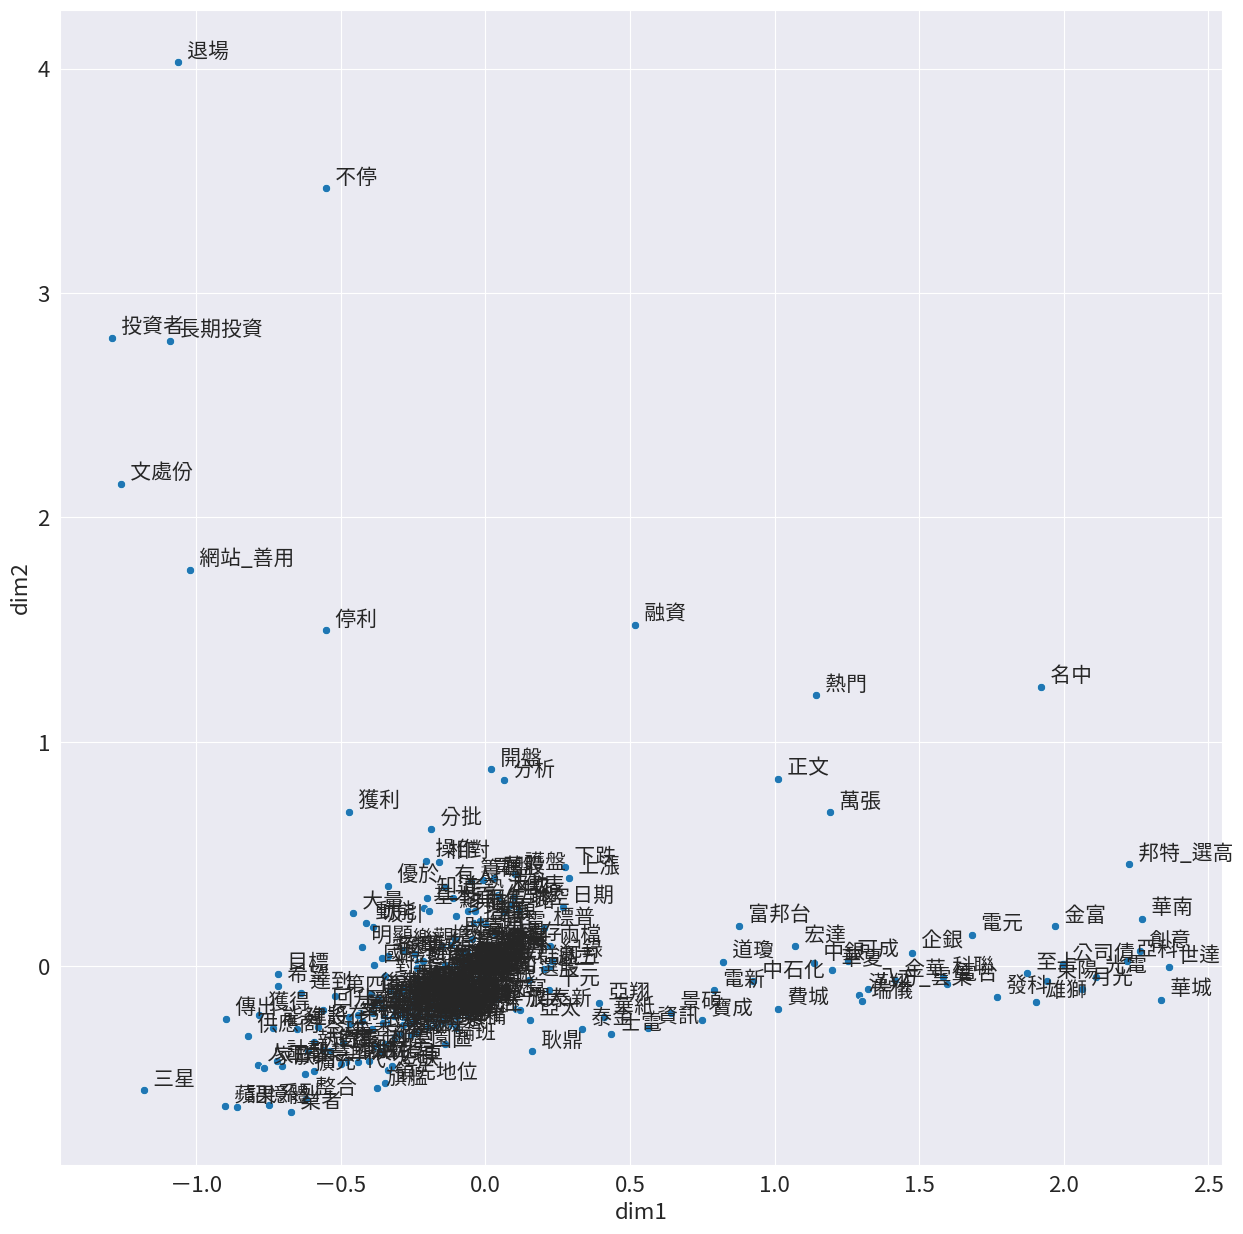

In [ ]:
plotScatter(word_df)

3D 散狀圖

In [ ]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


將字分群

In [ ]:
!pip install scikit-learn-extra

In [ ]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群

def cluster(X,method = 'kmedos',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [ ]:
new_feat.shape

(300, 3)

In [ ]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=8),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],
})
plotScatter3D(word_df)

黃色 : 晶片製造業、汽車業等一群，看到了有三星電子、汽車、晶圓、製程......等。  
紅色 : 股名(如元大、達電、玉山)或金融相關字詞(如道瓊、成交值)

#### (2)如何使用別人訓練好的word2vec模型

臺北醫學大學做的預訓練 Word2Vec 模型，來源：http://nlp.tmu.edu.tw/word2vec/index.html

In [ ]:
model_tmu = KeyedVectors.load_word2vec_format('./tmunlp_1.6B_WB_50dim_2020v1.bin', unicode_errors='ignore', binary=True)

In [ ]:
model_tmu.most_similar('癌症',topn=10)

[('肝癌', 0.8965061902999878),
 ('乳癌', 0.894655168056488),
 ('肺癌', 0.8924040198326111),
 ('肝病', 0.8478196859359741),
 ('大腸癌', 0.8448510766029358),
 ('糖尿病', 0.8433824181556702),
 ('口腔癌', 0.8214656710624695),
 ('疾病', 0.8192287683486938),
 ('胃癌', 0.8169611096382141),
 ('腸癌', 0.8160045742988586)]

In [ ]:
model_tmu.most_similar('咳嗽',topn=10)

[('流鼻水', 0.8725693225860596),
 ('鼻塞', 0.8663491010665894),
 ('嘔吐', 0.8655411601066589),
 ('腹瀉', 0.8551325798034668),
 ('感冒', 0.8539074063301086),
 ('乾咳', 0.8232213854789734),
 ('胸悶', 0.8225348591804504),
 ('胸痛', 0.8140345811843872),
 ('腹痛', 0.8083592057228088),
 ('頭暈', 0.8059035539627075)]

In [ ]:
model_tmu.most_similar(positive=['疾病','咳嗽'],topn=10)

[('症狀', 0.8799884915351868),
 ('癥狀', 0.8648518919944763),
 ('哮喘', 0.8594630360603333),
 ('慢性', 0.8578190803527832),
 ('氣喘', 0.8548911809921265),
 ('感冒', 0.8509713411331177),
 ('腹瀉', 0.8316847085952759),
 ('病症', 0.8148555159568787),
 ('急性', 0.8118695020675659),
 ('癲癇', 0.802987277507782)]

### Transformers Embeddings

#### 使用 Sentence-Transformer 套件   
參考資料：https://www.sbert.net/index.html

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from sentence_transformers import SentenceTransformer, models, util

#### 小模型，以BERT為範例

註：在挑選語言模型時需確認其訓練資料的來源，因為不一定都具備跨語言的能力。   
接下來將以針對英文、中文以及多語言進行訓練的三種BERT模型做範例。

In [ ]:
# 英文 bert-base-uncased
bert_en = SentenceTransformer('google-bert/bert-base-uncased')

bert_en.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

0

In [ ]:
bert_en.get_max_seq_length()

512

In [ ]:
example_text = "This framework generates embeddings for each input sentence"
example_embeddings = bert_en.encode(example_text)

print(example_embeddings.shape)
print("=======================")
print(example_embeddings)

(768,)
[-1.25634506e-01 -2.35394128e-02  9.72141698e-02 -2.14602068e-01
 -4.24759798e-02 -7.68916402e-03  1.66508600e-01  2.09751755e-01
  1.94057435e-01 -9.31541771e-02 -1.04051076e-01 -1.99633613e-01
 -3.48384231e-01  8.10464770e-02 -1.62067972e-02  1.90525934e-01
  5.29247976e-04  1.45439327e-01 -5.53637161e-04 -1.58491105e-01
  1.94275483e-01  1.59165829e-01 -5.99901617e-01  2.65522152e-01
  7.47945905e-01 -2.46572960e-03  1.04436599e-01  1.66958466e-01
 -3.53779286e-01  1.39418691e-01  3.89937088e-02  6.57109916e-01
 -6.23248192e-03 -2.85024047e-01 -1.56141147e-01  8.45851153e-02
  1.65655375e-01 -2.55370378e-01 -1.16442733e-01  9.59286317e-02
 -6.72327101e-01 -3.47994864e-01  8.42589587e-02 -2.06027731e-01
 -5.32228500e-02 -4.90707040e-01 -9.41141788e-03 -3.81041706e-01
  5.67958727e-02 -6.35588527e-01 -1.04700661e+00  3.73333395e-01
  1.31077528e-01  3.08177173e-01 -2.27984130e-01  8.04124296e-01
  1.21666558e-01 -7.21639931e-01  3.69302422e-01 -1.17349945e-01
  1.25592634e-01 -

In [ ]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy black dog leaps across the cat."
]

# 使用 encode() 對資料做embedding
embeddings_en = bert_en.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_en, embeddings_en)

# 印出句子間的cosine similarity分數
result = []
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
result_df.sort_values("score", ascending = False)

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy black dog leaps across the cat.,0.880907
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.499376
1,This framework generates embeddings for each i...,The speedy black dog leaps across the cat.,0.480858


因為後續在查看結果時會一直使用到此程式碼，所以包成function以便之後使用。

In [ ]:
# 回傳cosine similarity分數
def get_result_df(sentences, cosine_scores):

  result = []
  for i in range(len(sentences)):
      for j in range(i+1, len(sentences)):
          result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

  result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
  result_df = result_df.sort_values("score", ascending = False)

  return result_df

中文 bert-base-chinese

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

In [ ]:
# 示範句子
sentences = [
    "今天天氣很好。",
    "今天是個晴空萬里的好天氣。",
    "我晚上想去公園散步。"
]

# 使用 encode() 對資料做embedding
embeddings_ch = bert_ch.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_ch, embeddings_ch)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
0,今天天氣很好。,今天是個晴空萬里的好天氣。,0.914067
1,今天天氣很好。,我晚上想去公園散步。,0.787589
2,今天是個晴空萬里的好天氣。,我晚上想去公園散步。,0.759642


多語言 bert-base-multilingual-cased

In [ ]:
# 多語言 bert-base-multilingual-cased
bert_multi = SentenceTransformer('google-bert/bert-base-multilingual-cased')

bert_multi.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

0

In [ ]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的棕色狐狸跳過了懶惰的狗。"
]

# 使用 encode() 對資料做embedding
embeddings_multi = bert_multi.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_multi, embeddings_multi)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,敏捷的棕色狐狸跳過了懶惰的狗。,0.588525
1,This framework generates embeddings for each i...,敏捷的棕色狐狸跳過了懶惰的狗。,0.362766
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.350700


### 使用embedding做NLP任務

#### 相似文件

In [ ]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].astype(str)
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(20)

<ipython-input-62-5c6d56aa5769>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-62-5c6d56aa5769>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,system_id,artTitle,artContent
0,1,[標的]00712富時不動產天天大溢價要賣？,標的富時不動產例台積電分類討論分析正文這隻已經超過一周都大溢價趴股價卻沒有急速下跌是每天凌遲...
1,2,[新聞]金融存股勇士進場了！9家金控股東人數創,原文標題金融存股勇士進場了家金控股東人數創史上新高原文連結發布時間年月日週一上午記者署名葉憶...
2,3,[標的]2753八方雲集鍋貼空,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...
3,4,[情報]0320上市外資買賣超排行,標題外資買賣超排行來源台灣證交所網址內文買超緯創飛宏光罩華邦電樂事綠能京元電子宏達電元晶臺企...
4,5,[情報]6667信紘科111年5.11股利4.24,提報董事會或經董事會決議日期審計委員會通過日期財務報告或年度自結財務資訊報導期間起訖日期月日...
5,6,[情報]112/03/20八大公股銀行買賣超排行,標題八大公股銀行買賣超排行來源玩股網網址內文手機介面圖片好讀版以下資訊依張數排列買超賣超排名...
6,7,[標的]敦泰3545多重啟多頭循環炒作,發標的文未充實內文多空理由不充實者板規或處份進退場機制若非長期投資請輸入停損價否則依板規處份...
7,8,[情報]112年03月20日信用交易統計,標題年月日信用交易統計來源臺灣證券交易所證券櫃檯買賣中心公司名網站名網址請善用縮網址工具內文...
8,9,Re:[標的]SCHWUS,後來賣出觀察了一下發現他似乎衝不太破這個關卡但到這邊又有支撐於是又回頭試了一下小賺趴如果他又...
9,10,[標的]NDAQUS,標的例台積電分類多空討論心得多分析正文那斯達克對他是一間公司全球最大證券交易所財報沒問題股價...


bert_ch

In [ ]:
corpus_embeddings = bert_ch.encode(df_similar['artContent'], convert_to_tensor=True)

query_num = 30 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [新聞]高嘉瑜握23檔股票「擁6張台積電」　總價

 資料集中前五相似的文章:
[新聞]高嘉瑜握23檔股票「擁6張台積電」　總價 (Score: 1.0000)
[新聞]「港湖女神」驚人身家曝！狠押台積電等23 (Score: 0.9869)
[新聞]ETF成媽媽股民最愛定期定額排行擠下台 (Score: 0.9724)
[新聞]臺灣50指數懂AI外資按讚 (Score: 0.9724)
[新聞]挪威主權基金加碼台積電買進台股升至497 (Score: 0.9722)






「高嘉瑜握23檔股票「擁6張台積電」　總價」內容是在說，監察院公布民進黨立委高嘉瑜存款多達403萬2190元，特別的是手上還握有23檔股票，其中台積電就有6張，相較於去年資料多了4張。  
相關的新聞，前兩個都是與高嘉瑜相關的新聞。  
除此之外，三、四的文章主要都是說明台灣ETF中的代表0050與台積電的關係，在0050當中最大成分股就是台積電。  
第五的文章則是挪威主權財富基金與台積電的關係，全球最大的主權財富基金挪威主權財富基金，去年擴大投資台灣企業，增持台積電（2330）、聯發科等台股。  

In [ ]:
query_num = 10

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [新聞]宣明智大膽預測未來5年台IC設計市佔衝5成

 資料集中前五相似的文章:
[新聞]宣明智大膽預測未來5年台IC設計市佔衝5成 (Score: 1.0000)
Fw:[新聞]台灣美光董事長專訪 (Score: 0.9867)
[新聞]先進製程競賽勝負未底定英特爾直攻 (Score: 0.9853)
[新聞]張忠謀：台晶片具3大優勢他國很難做到 (Score: 0.9851)
[新聞]美國能贏得晶片大戰？Google前執行長認了 (Score: 0.9850)






「[新聞]宣明智大膽預測未來5年台IC設計市佔衝5成」主要是說明某分析師宣明智認為台灣台積電的IC製程市場未來一片看好，且中美晶片戰爭之下，美國勢必要拉攏台積電進去美國設廠。  
因此，我們可看到與此新聞相關的主要都是跟台積電、製程、晶片以及中美晶片戰爭等新聞